# Site Object

For a given position, reference wind speed `ws` and reference wind direction `wd` or time, `Site` provides the local wind condition in terms of local wind speed `WS`, local wind direction `WD`, local turbulence intensity `TI` and the probability of each flow case (wd-ws combination or time). Furthermore, `Site` contains a `Distance` object responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines. The distances can be either straight-line, terrain-elevation-following or streamline-following distances.

In [1]:
import os
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy import newaxis as na
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from py_wake import NOJ, NOJLocal
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite, ParqueFicticio_path
from py_wake.examples.data.dtu10mw._dtu10mw import DTU10MW
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, Hornsrev1WRFSite, V80
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.flow_map import XYGrid
from py_wake.site import UniformSite, UniformWeibullSite, WaspGridSite, XRSite
from py_wake.site.distance import StraightDistance
from py_wake.site.shear import PowerShear
from py_wake.utils import layouts
from py_wake.utils import weibull
from py_wake.utils.maps import dk_coast
from py_wake.utils.plotting import setup_plot
import xarray as xr
xr.set_options(display_expand_data=True);

## Example sites

PyWake has a few predefined demonstration sites:

- **IEA37Site**: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability).
- **Hornsrev1**: `UniformWeibullSite` (Weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area).
- **ParqueFicticioSite**: `WaspGridSite` (position-dependent Weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP.
- **Hornsrev1WRF**: Time and position dependent wind speed and direction. The site covers Hornsrev1, April 2020. Streamline-following distances

In [2]:
sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite(),
         "Hornsrev1WRF": Hornsrev1WRFSite()}

## User-defined sites

You can define your own site using one of the `Site` classes:

- [UniformWeibullSite](#UniformWeibullSite): Site with uniform sector-dependent Weibull distributed wind speed.
- [XRSite](#XRSite): The flexible general base class behind all Sites.
- [WaspGridSite](#WaspGridSite): Site with gridded non-uniform inflow based on *.grd files exported from WAsP.
- [WRFSite](#WRFSite): A subclass of `XRSite` which take a WRF netcdf as input containing time and position dependent `WS`, `WD` and `TKE`/`TI`

For more information on these classes, please see the [API reference on the Site object](https://topfarm.pages.windenergy.dtu.dk/PyWake/api/Site.html).

## UniformSite
`UniformSite` has a single default wind speed and 360 wind directions. I.e. the inflow-case probability `P` used for AEP will be constant and only depend on wind direction.

In [3]:
site = UniformSite(ws=12, ti=0.1)

NOJ(site, V80())([0],[0])[['WS','P']]

<xarray.SimulationResult> Size: 6kB
Dimensions:  (wd: 360)
Coordinates:
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
Data variables:
    WS       int64 8B 12
    P        (wd) float64 3kB 0.002778 0.002778 0.002778 ... 0.002778 0.002778

## UniformWeibullSite
`UniformWeibullSite` has default wind speeds from 3-25 m/s and 360 wind directions.

In [4]:
#specifying the necessary parameters for the UniformWeibullSite object
site = UniformWeibullSite(p_wd = [.20,.25,.35,.25],                         # sector frequencies
                          a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
                          k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
                          ti = 0.1                                          # turbulence intensity, optional
                         )

sim_res = NOJ(site, V80())([0],[0])[['WS','P']]
sim_res

<xarray.SimulationResult> Size: 69kB
Dimensions:  (ws: 23, wd: 360)
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
Data variables:
    WS       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
    P        (wd, ws) float64 66kB 0.0001139 0.0001586 ... 1.063e-07 4.064e-08

I.e. the inflow-case probability `P` used for AEP will be weibull and sector-frequency distributed and depend on both wind direction and wind speed

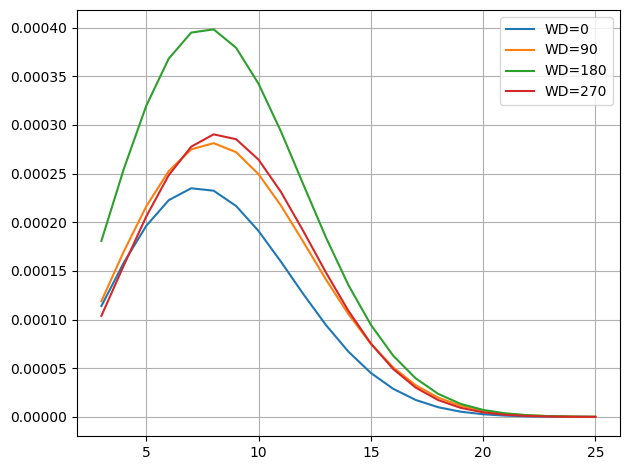

In [5]:
for P_ws in sim_res.P[::90]:
    P_ws.plot(label=f'WD={P_ws.wd.item()}')
setup_plot()

## XRSite

The `XRSite` is the most general and flexible `Site`. For the input dataset there are some required and optional data variables, such as:

- Required data variables:
    - `P`: probability of flow case(s)

    or

    - `Weibull_A`: Weibull scale parameter(s)
    - `Weibull_k`: Weibull shape parameter(s)
    - `Sector_frequency`: Probability of each wind direction sector
    

- Optional data variables:

    - `WS`: Wind speed, if not present, the reference wind speed `ws` is used
    - `Speedup`: Factor multiplied to the wind speed
    - `Turning`: Wind direction turning
    - `TI`: Turbulence intensity
    - xxx: Custom variables needed by the wind turbines to compute power, ct or loads
    

- Each data variable may be constant or depend on a combination of the following inputs (Note, the input variables must be ordered according to the list, i.e. `P(wd,ws)` is ok, while `P(ws,wd)` is not):

    - `i`: Wind turbine position (one position per wind turbine)
    - `x`,`y`: Gridded 2d position
    - `x`,`y`,`h`: Gridded 3d position
    - `time`: Time
    - `wd`: Refernce wind direction
    - `ws` : Reference wind speed

In [6]:
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = np.linspace(0, 360, len(f), endpoint=False)
ti = .1

### Uniform site

In [7]:
# Site with constant wind speed, sector frequency, constant turbulence intensity and power shear
uniform_site = XRSite(
    ds=xr.Dataset(data_vars={'WS': 10, 'P': ('wd', f), 'TI': ti},
                  coords={'wd': wd}),
    shear=PowerShear(h_ref=100, alpha=.2))

### Wind direction dependent weibull distributed wind speed

In [8]:
# Site with wind direction dependent weibull distributed wind speed
uniform_weibull_site = XRSite(
    ds=xr.Dataset(data_vars={'Sector_frequency': ('wd', f), 'Weibull_A': ('wd', A), 'Weibull_k': ('wd', k), 'TI': ti},
                  coords={'wd': wd}))

### Wind turbine dependent speedup and turning

In [9]:
# Site with a speedup and a turning value per WT
x_i, y_i = np.arange(5) * 100, np.zeros(5)  # WT positions

complex_fixed_pos_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': ('i', np.arange(.8, 1.3, .1)),
                   'Turning': ('i', np.arange(-2, 3)),
                   'P': ('wd', f)},
        coords={'i': np.arange(5), 'wd': wd}),
    initial_position=np.array([x_i, y_i]).T)

### Position dependent speedup

In [10]:
# Site with gridded speedup information
complex_grid_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['x', 'y'], np.arange(.8, 1.4, .1).reshape((3, 2))),
                   'P': ('wd', f)},
        coords={'x': [0, 500, 1000], 'y': [0, 500], 'wd': wd}))

### WS dependent speedup, custom (wd,ws)-dependent propability

In [11]:
# Site with ws dependent speedup and wd- and ws distributed probability
P_ws = weibull.cdf(np.array([3, 5, 7, 9, 11, 13]), 10, 2) - weibull.cdf(np.array([0, 3, 5, 7, 9, 11]), 10, 2)
P_wd_ws = P_ws[na, :] * np.array(f)[:, na]

complex_ws_site = XRSite(
    ds=xr.Dataset(
        data_vars={'Speedup': (['ws'], np.arange(.8, 1.4, .1)),
                   'P': (('wd', 'ws'), P_wd_ws), 'TI': ti},
        coords={'ws': [1.5, 4, 6, 8, 10, 12], 'wd': wd}))

### Position and time dependent wind resources

This example creates a site with 2D non-uniform time series resources for wind speed (ws), wind direction (wd), and turbulence intensity (ti). The data is provided as arrays with dimensions corresponding to spatial coordinates (x, y) and time.

Mean wind speed at the mean location: 12.02 m/s


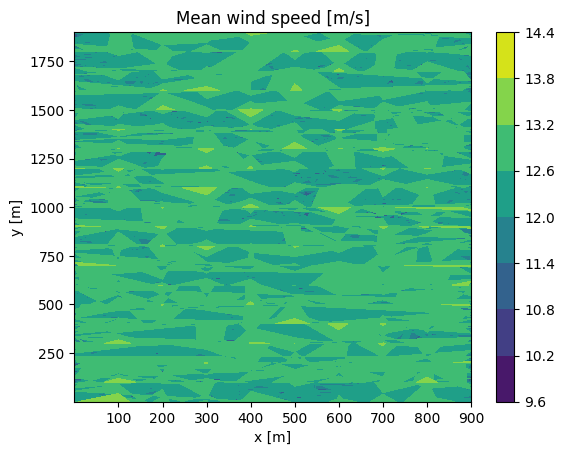

In [12]:
site_x, site_y = np.meshgrid(np.arange(0.1, 1000, 100), np.arange(0.1, 2000, 100))
site_x, site_y = site_x.flatten(), site_y.flatten()
site_time = np.arange(100)
site_ws = np.random.uniform(3.0, 21.0, (len(site_x), len(site_y), len(site_time)))
site_wd = np.random.uniform(0.0, 360.0, (len(site_x), len(site_y), len(site_time)))
ds = xr.Dataset(
    data_vars=dict(
        WS=(["x", "y", "time"], site_ws),
        WD=(["x", "y", "time"], site_wd),
        TI=(["x", "y", "time"], np.ones_like(site_ws) * 0.1),  # hardcoded TI=0.1
        P=1,  # deterministic wind resource
    ),
    coords=dict(
        x=("x", site_x),
        y=("y", site_y),
        time=("time", site_time),
    ),
)
non_uniform_ts_site = XRSite(ds)
wss_at_mean_loc = non_uniform_ts_site.local_wind(
    site_x.mean(), site_y.mean(), time=site_time
)["WS_ilk"]
print(f"Mean wind speed at the mean location: {wss_at_mean_loc.mean():.2f} m/s")

# check the map of the mean wind speed at the site
mean_resource = ds.WS.mean(dim="time").values
plt.contourf(site_x, site_y, mean_resource)
plt.colorbar()
plt.title("Mean wind speed [m/s]")
plt.xlabel("x [m]")
_ = plt.ylabel("y [m]")

## WaspGridSite
The `WaspGridSite` is a special `XRSite` that uses WAsP grd files as input. The `grd` files contains gridded information, e.g. weibull parameters, different kind of wind speed and wind direction turning as well as elevation. These are converted into `Speedup`, `Turning` and `Elevation`.

In [13]:
site = WaspGridSite.from_wasp_grd(ParqueFicticio_path, distance=StraightDistance())

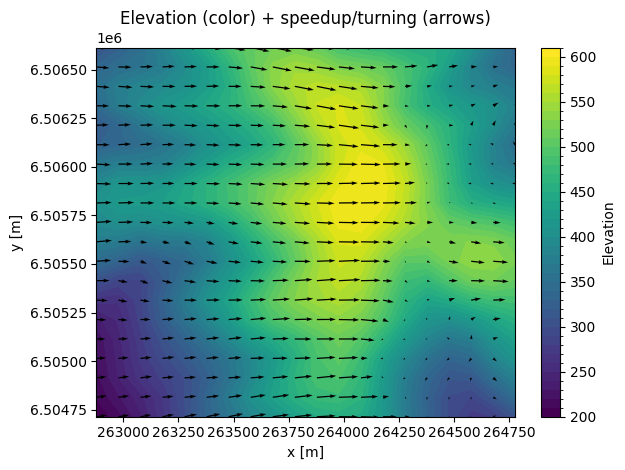

In [14]:
ds = site.ds.sel(h=30, wd=270)
X,Y = np.meshgrid(ds.x.values,ds.y.values)
site.ds.Elevation.plot.contourf(levels=50, x='x')
theta = np.deg2rad(ds.Turning)
plt.quiver(X,Y, (np.cos(theta)*ds.Speedup).T, (np.sin(theta)*ds.Speedup).T)
setup_plot(grid=False, xlabel='x [m]', ylabel='y [m]', title='Elevation (color) + speedup/turning (arrows)')

Note, that in the current implementation, `WaspGridSite` has both position-dependent weibull distributions and speedup:

In [15]:
site.ds[['Sector_frequency', 'Weibull_A', 'Weibull_k']]

<xarray.Dataset> Size: 250kB
Dimensions:           (x: 20, y: 20, h: 2, wd: 13)
Coordinates:
  * x                 (x) float64 160B 2.629e+05 2.63e+05 ... 2.648e+05
  * y                 (y) float64 160B 6.505e+06 6.505e+06 ... 6.507e+06
  * h                 (h) float64 16B 30.0 200.0
  * wd                (wd) float64 104B 0.0 30.0 60.0 90.0 ... 300.0 330.0 360.0
Data variables:
    Sector_frequency  (x, y, h, wd) float64 83kB 0.05179 0.02514 ... 0.05213
    Weibull_A         (x, y, h, wd) float64 83kB 2.28 1.635 ... 7.188 5.752
    Weibull_k         (x, y, h, wd) float64 83kB 1.764 2.107 ... 1.826 2.053
Attributes:
    sector_width:  30.0

 See why this is a problem in the section [Local wind speed vs. position-dependent weibull distribution](#Local-wind-speed-vs.-position-dependent-weibull-distribution) below. 

To overcome this problem, we need to find a grid point with a weibull distribution and sector frequency that are representative for the reference wind speed and direction and use that to overwrite the distributed distributions.

The code below is an attempt to do that

In [16]:
site = WaspGridSite.from_wasp_grd(ParqueFicticio_path, distance=StraightDistance())

# find local point with close to neutral speedup and turning
da = (np.abs(site.ds.Speedup - 1) + np.abs(site.ds.Turning)/10) # divide turning by 10 as its deviation from 0 is larger than the deviation of speedup
da = da.sum('wd')
da = da.where(da==da.min(), drop=True).squeeze()
rep_ds = site.ds.sel(x=da.x, y=da.y, h=da.h) # dataset with representative weibull distribution and sector frequency

for n in ['Sector_frequency', 'Weibull_A', 'Weibull_k']:
    site.ds[n] = rep_ds[n] # overwrite properties
site.ds[['Sector_frequency', 'Weibull_A', 'Weibull_k']]

<xarray.Dataset> Size: 416B
Dimensions:           (wd: 13)
Coordinates:
  * wd                (wd) float64 104B 0.0 30.0 60.0 90.0 ... 300.0 330.0 360.0
Data variables:
    Sector_frequency  (wd) float64 104B 0.06027 0.02844 ... 0.08817 0.06027
    Weibull_A         (wd) float64 104B 6.33 5.437 6.677 ... 10.81 7.491 6.33
    Weibull_k         (wd) float64 104B 2.033 2.385 3.018 ... 2.002 1.799 2.033
Attributes:
    sector_width:  30.0

Note, the weibull and sector distributions are now depending on wind direction only.

## WRFSite

Load a 12 hour time slice of the example `WRFSite`, `Hornsrev1WRFSite`

In [17]:
site = Hornsrev1WRFSite(time_slice=slice(f"2020-04-27 12:00", f"2020-04-27"))

After loading, the site contains a xarray dataset with the following contents

In [18]:
site.ds

<xarray.Dataset> Size: 293kB
Dimensions:   (x: 18, y: 14, h: 4, time: 24, ws: 1)
Coordinates:
  * x         (x) float64 144B -4.62e+05 -4.59e+05 ... -4.14e+05 -4.11e+05
  * y         (y) float64 112B 1.62e+05 1.65e+05 1.68e+05 ... 1.98e+05 2.01e+05
  * h         (h) float32 16B 50.0 75.0 100.0 150.0
  * time      (time) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * ws        (ws) int64 8B 0
    XLAT      (x, y) float32 1kB ...
    XLON      (x, y) float32 1kB ...
    crs       int8 1B ...
Data variables:
    WD        (x, y, h, time) float32 97kB ...
    WS        (x, y, h, time) float32 97kB ...
    TI        (x, y, h, time) float32 97kB 0.03588 0.04188 ... 0.02584 0.04355
    P         int64 8B 1
    datetime  (time) datetime64[ns] 192B 2020-04-27T12:00:00 ... 2020-04-27T2...
Attributes: (12/117)
    ADAPT_DT_MAX:                    15.0
    ADAPT_DT_MIN:                    3.0
    ADAPT_DT_START:                  13.0
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    ...                              ...
    USE_THETA_M:                     0
    WEST-EAST_GRID_DIMENSION:        1598
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    sector_width:                    360
    initial_position:                [[-444357.78223744  183555.9888552 ]\n [...

Setup a wind farm with 36 DTU10MW wind turbines in a circular array

In [19]:
wts= DTU10MW()
wt_x, wt_y = layouts.circular([1, 5, 12, 18], 1800) + [[-441805.7168979],  [181458.7685485]]
wt_h = wts.hub_height()
wf_x, wf_y, wf_h = np.mean([wt_x.min(), wt_x.max()]), np.mean([wt_y.min(), wt_y.max()]), np.mean(wt_h)

Extract time series of wind direction and wind speed at the center of the wind farm

In [20]:
wd, ws = site.ds.WD.interp(x=wf_x, y=wf_y, h=wf_h, method='nearest').values, site.ds.WS.interp(x=wf_x, y=wf_y, h=wf_h).values

Run simulation

In [21]:
wfm = NOJLocal(site, wts)
sim_res = wfm(wt_x, wt_y, ws=ws, wd=wd, time=True)

In [22]:
def get_plot(ax, sim_res, levels=np.linspace(4,15,21)):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    e = 15000
    grid = XYGrid(np.linspace(wf_x - 10000, wf_x + e,500), np.linspace(wf_y-e,wf_y+e,500), wf_h)

    # quiver data
    X,Y = np.meshgrid(site.ds.x.values, site.ds.y.values)    
    theta = np.deg2rad(270-site.ds.WD)
    WS = site.ds.WS
    Vx,Vy = np.cos(theta)*WS, np.sin(theta)*WS

    
    import windkit as wk
    crs = wk.spatial.get_crs(site.ds)
    dk = dk_coast(crs)
    
    def p(t):
        ax.cla()
        dk.plot(ax=ax, color='k')
        site.ds.WS.isel(time=t).interp(h=wf_h).plot.contourf(cmap='Blues_r', ax=ax, levels=levels, add_colorbar=False, x='x')
        sim_res.flow_map(grid, time=t).plot_wake_map(levels=levels, ax=ax, cax=cax, plot_windturbines=False)
        wts.plot(wt_x, wt_y, wt_number=0, ax=ax)
        ax.quiver(X,Y, Vx.isel(time=t).interp(h=wf_h).values.T, Vy.isel(time=t).interp(h=wf_h).values.T)
        setup_plot(ax=ax, grid=False, title=f'{t} {site.ds.datetime[t].dt.strftime("%Y-%m-%d %H:%M:%s").item()}', 
                  xlim=[site.ds.x.min().item(), -400000], ylim=[site.ds.y.min().item(), site.ds.y.max().item()]
    )
    return p 

In [23]:
# make animations for figures below
os.makedirs('images', exist_ok=True)
fn = f'images/hornsrev_streamlines.gif'
if not os.path.isfile(fn):
    fig, ax = plt.subplots(figsize=(8,6))
    levels=np.linspace(np.maximum(np.floor(ws.min().item()) - 5,0), np.ceil(ws.max().item()))
    animate = get_plot(ax, sim_res, levels)
    animation = FuncAnimation(fig, animate, frames=tqdm(sim_res.time.values), interval=1000)
    writergif = PillowWriter(fps=2)
    animation.save(fn, writer=writergif)
    plt.close()
HTML(f"<img src='{fn}'>")

## Local wind speed vs. position dependent weibull distribution

Local wind speed, `WS`, can be specified in absolute values `WS(x,y,h,ws)` or as local a `Speedup(x,y,h)` factor that is multiplied to the reference wind speed `ws`. Using this approach, wind turbines will see the specified local wind speed, `WS` subtracted the deficit from other wind turbines.

An alternative tempting approach is to use position-dependent weibull parameters. This means that wind turbines will see the reference wind speed, `ws´ subtracted the deficit from other wind turbines, but the weight of each flow case when summing up the AEP will be position dependent. This approach, however, is mixing up flow cases and should be avoided, see example below.

Espeically it is important to avoid using both approaches as the local variation will be taken into accound twice.

Assume we have the site shown above with a constant reference wind speed, `ws=9m/s` and wind direction `wd=270deg` and two wind turbine as shown below.

The local wind speed without wakes, `WS`, is seen to vary due to lcoal `Speedup` and the deficit from the upstream turbine subtracts 2.5m/s from the effective wind speed, `WS_eff` of the downstream turbine.

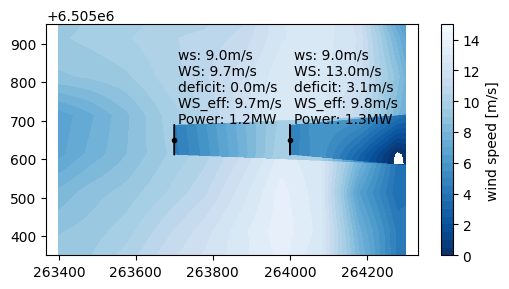

In [24]:
levels=np.linspace(0,15,31)
plt.figure(figsize=(6,3))
site = WaspGridSite.from_wasp_grd(ParqueFicticio_path, distance=StraightDistance())
sim_res = NOJLocal(site, V80())([263700, 264000], [6505650, 6505650], ws=9, wd=270, TI=0.1)
sim_res.flow_map(XYGrid(extend=0.3)).plot_wake_map(levels=levels, plot_windturbines=False)
sim_res.windFarmModel.windTurbines.plot(sim_res.x, sim_res.y,wt_number=False, wd=270)
def get_text(sim_res):
    return [f'''ws: {sr.ws.item():.1f}m/s
WS: {sr.WS.item():.1f}m/s
deficit: {(sr.WS-sr.WS_eff).item():.1f}m/s
WS_eff: {sr.WS_eff:.1f}m/s
Power: {sr.Power.item()*1e-6:.1f}MW
''' for sr in [sim_res.isel(wt=i,wd=0,ws=0) for i in [0,1]]]
s = get_text(sim_res)
plt.annotate(s[0], (sim_res.x[0]+10, sim_res.y[0]))
plt.annotate(s[1], (sim_res.x[1]+10, sim_res.y[1]));

If this example was modelled with distributed local flow-case probabilities instead of local speedup, the local flow-case probabilities would mean that the upstream wind turbine always sees the reference wind speed, `ws=9.7m/s` (left plot below), while the downstream wind turbine sees the refernce wind speed, `ws=13.0m/s` (right plot below). 

The local speedup is thereby already taken into account, and the local wind speed `WS` equals the reference wind speed. The deficit from the upstream turbine seeing 9.7m/s is therefore also 3.1m/s as it should be. So far, everything matches the situation seen above.

The power of the downstream turbine, however, is wrong as it is extracted from the situation in the right plot below. The problem is that the deficit from the upstream wind turbine is calculated for an inflow wind speed of 13m/s instead of 9.7m/s. In other words, the results of the individual wind turbines can be modelled correctly with the distributed probability approach, but the interaction becomes wrong.

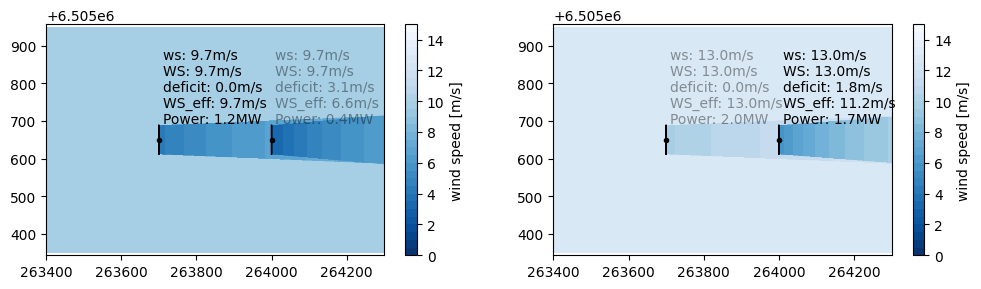

In [25]:
axes = plt.subplots(1,2, figsize=(12,3))[1]
for i, (ax, ws) in enumerate(zip(axes, sim_res.WS.values)):
    sim_res_uni = NOJLocal(UniformSite(), V80())(sim_res.x, sim_res.y, ws=ws, wd=270, TI=0.1)
    sim_res_uni.flow_map(XYGrid(extend=0.3)).plot_wake_map(ax=ax, levels=levels, plot_windturbines=False)
    sim_res_uni.windFarmModel.windTurbines.plot(sim_res.x, sim_res.y,wt_number=False, wd=270, ax=ax)
    s = get_text(sim_res_uni)
    ax.annotate(s[0], (sim_res.x[0]+10, sim_res.y[0]), alpha=[1,0.4][i])
    ax.annotate(s[1], (sim_res.x[1]+10, sim_res.y[1]), alpha=[0.4,1][i]);    

## Distance

The wake effects depends on the downwind, crosswind and vertical distances between wind turbines. These distances are calculated by a `Distance` object, which is an input to the `Site`. There are currently three different distance classes

- `StraightDistance`: Calculate the straight-line distances between wind turbines. Default distance object for most flat sites, e.g. `IEA37Site` and the `Hornsrev1Site` 
- `TerrainFollwingDistance`: Calculate the down-wind distance along a line with constant height above ground. Default distance object for `WaspGridSite` e.g. `ParqueFicticioSite`.
- `StreamlineDistance`: Calcualte the downwind, crosswind and vertical distances along streamlines. Default for `WRFSite` (if the streamline argument is set to True), e.g. `Hornsrev1WRFSite`

In [26]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    
    dw_ijlk, cw_ijlk, dh_ijlk = site.distance(src_x_ilk=[wt_x], src_y_ilk=[wt_y], src_h_ilk=[70], wd_l=wd,
                                              time=[1281, 1281, 1281], # all 3 wd calculated at same time step
                                              dst_xyh_jlk=([wt_x], [wt_y-2000], [90]))
    
    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijlk[0,0,:,0]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijlk[0,0,:,0]))
    dh_ijlk = np.broadcast_to(dh_ijlk, dw_ijlk.shape)
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijlk[0,0,:,0]))
    print()
    

------- IEA37 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	2000.0		1732.1		0.0
Cross wind distance [m]: 	0.0		1000.0		2000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	2000.0		1732.1		0.0
Cross wind distance [m]: 	0.0		1000.0		2000.0
Height difference [m]: 		20.0		20.0		20.0

------- ParqueFicticio -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	nan		nan		nan
Cross wind distance [m]: 	0.0		1000.0		2000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1WRF -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	2177.2		2997.4		0.0
Cross wind distance [m]: 	-857.1		-1441.5		2000.0
Height difference [m]: 		20.0		20.0		20.0



### Streamline distance

The `StreamlineDistance` takes a vector field or function as input and computes the streamline from e.g. a wind turbine and downstream. The downwind distance is then calculated as the distance along the streamline until the point where the streamline intersects with the rotor plane of the downstream wind turbine, and the cross-wind and vertical distance as the distance from the intersection point to the center of the rotor.

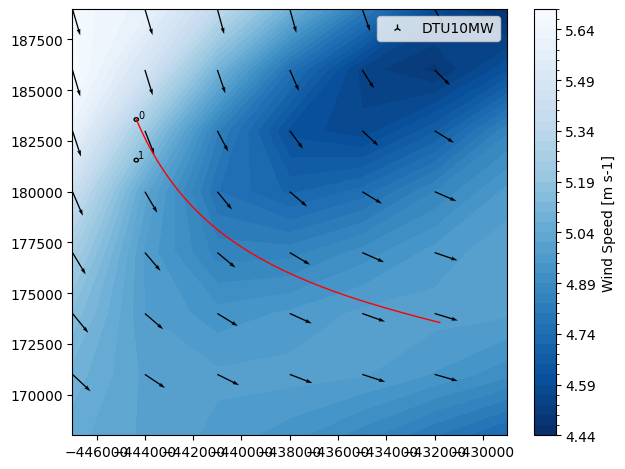

In [27]:
site = sites['Hornsrev1WRF']
t = 1281
ds = site.ds.sel(time=t).interp(h=119)
sx, sy = slice(5,-6), slice(2,-4)
X,Y = np.meshgrid(ds.x.values[sx], ds.y.values[sy])  
theta = np.deg2rad(270-ds.WD[sx,sy])
WS = ds.WS[sx,sy]
Vx,Vy = np.cos(theta)*WS, np.sin(theta)*WS
ds.WS[sx,sy].plot.contourf(levels=50, x='x', cmap='Blues_r')
plt.quiver(X, Y, Vx.T, Vy.T, alpha=1, width=.003)

wt_x, wt_y = site.initial_position[[0]].T

stream_lines = site.distance.vectorField.stream_lines(wd=np.full_like(wt_x,0), start_points=np.array([wt_x, wt_y, np.full_like(wt_x,wf_h)]).T,
                                                      time=np.array([t]), dw_stop=np.full_like(wt_x,10000))
for sl in stream_lines:
    plt.plot(sl[:, 0], sl[:, 1], 'r', lw=1)
wts.plot([wt_x,wt_x],[wt_y,wt_y-2000])
setup_plot(grid=False)

## Wind resource distribution plots

The `Site` object has a few plot function to visualize its properties, mainly the wind resource given by the wind rose and the probability functions.

In [28]:
site = sites['Hornsrev1']

Plotting wind rose.

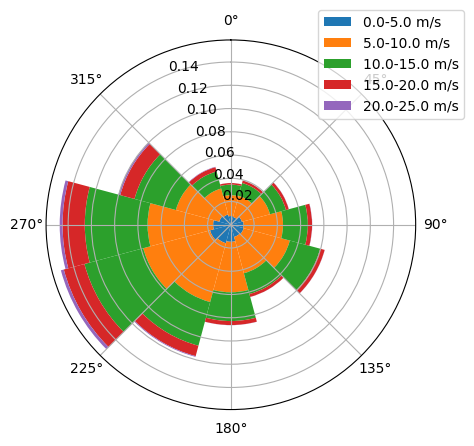

In [29]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25])

Plotting probability density function for the four sectors studied.

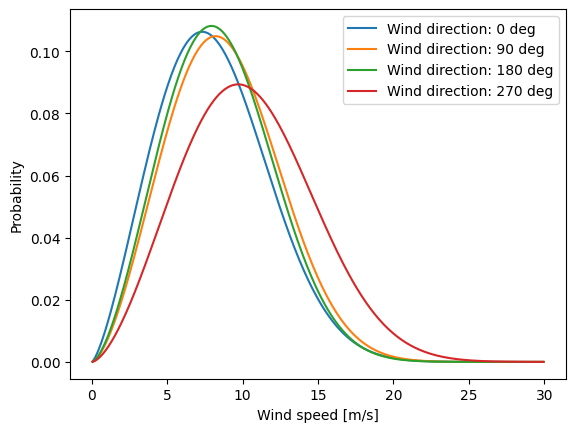

In [30]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

Plotting probablity density function for the four sector studied $\pm$ 45 degrees.

If **include_wd_distribution=true**, the wind speed probability distributions are multiplied by the wind direction probability.

The sector size is set to 360 / len(wd). This only makes sense if the wd array is evenly distributed

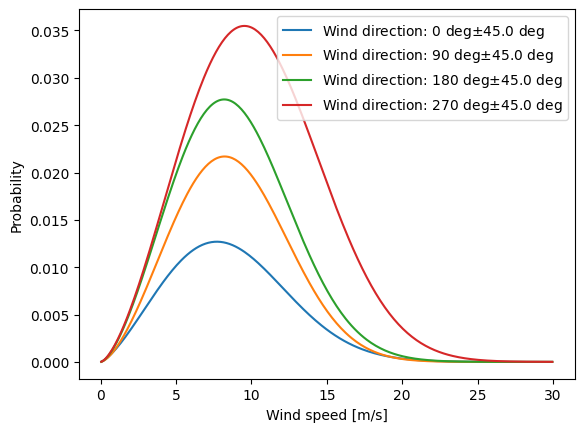

In [31]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)